# MLE - Exercise 2 - Comparative Experimentation
## Andreas Kocman (se19m024)

## Assignment
In this exercise, you shall experiment with a number of (simple) algorithms on several datasets. The aim is to get a feeling how well each of these algorithms works, and whether there are differences depending on the dataset.

The datasets are
* [Iris](https://archive.ics.uci.edu/ml/datasets/Iris), for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)
* [Handwritten digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), of which we only use the test set of 1797 instances; for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
* If you are a group of three (see below): [Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)); skip the ID field; in Python: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

The classifiers you shall use are
* k-NN (with 3 different values for k)
* Naive Bayes
* Perceptron, and
* Decision Trees with 3 different parameter settings (e.g. some pre-pruning setting, different split criterion, ...)

For each dataset, you shall train and evaluate each classifier (with parameter variations), and then compute several evaluation metrics
* Effectiveness: Accuracy, and 1 more of your choice (precision, recall, F1, ...
* Efficiency: runtime for training & testing
* As evaluation set splitting technique, you shall use once the holdout method with 2/3 training and the rest for testing, and once cross validation with 5 folds.

You shall present these results in a tabular form, with one table for each dataset & splitting combination approach.

Iris/5-folds | Accuracy | Precision| Training time | Testing time
---|---|---|---|---|---
k-NN (3-NN) | .85 | .82 | 0.1 sec | 27 sec
Naive Bayes | .72 | .82 | 1 sec | 2 sec
Decision Tree | .92 | .76 | 5 sec | 2 sec
... | ... | ...| ... | ...

Then describe the results, and analyse e.g.:
* Which classifiers work best?
* Are there differences between the datasets?
* Are the differences in the efficiency measurements?
* How is the runtime changing with the different data sets?
* ...

You can solve this exercise alone, or in a group of two students. If you form a group, you need to extend your scope, by
* Adding a third dataset, namely breast cancer wisconsin
* For k-NN, using 5 different values for k instead of 3, and use both weighted and uniform distance (i.e. a total of 10 combinations); for Decision Trees, also add 3 more parameter variations
* Adding a third efficiency evaluation metric

## Deliverables
Your submission shall contain
* The textual report
* All code samples and
* All data sets (if not already included in your software package, e.g. Python)

## Sources used
* Scikit documentation
* https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/

## General Imports and Helper Classes

In [1]:
#General Imports
import numpy as numpy
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
import pandas as pd
import time

#Data reporting
from IPython.display import display

#Global variables
randomState=24  # change the state with the numeric parts of your matrikelnummer; if you are in a group, use the sume of the numeric parts
                # se19m024
datasets_used = [('iris', datasets.load_iris()),('digits', datasets.load_digits())]
averagingApproach = 'macro'
zero_divisionApproach = 0
number_of_folds = 5
scoring = {'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score, average=averagingApproach, zero_division=zero_divisionApproach),
            'Recall': make_scorer(recall_score, average=averagingApproach, zero_division=zero_divisionApproach)}

#Helper funcitons
def parse_k_fold_results(results):
    return "m: " + str(numpy.average(results)) + " std: " + str(numpy.std(results)) # + " values: " + str(results)

def parse_k_fold_timings(results):
    return "total: " + str(numpy.sum(results)) + " values: " + str(results)

## k-NN

In [2]:
from sklearn import neighbors

knn_results = []

# parameters for k-NN
n_neighbors = [5,10,20]

for dataset in datasets_used:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    for n in n_neighbors:
        # train the k-NN
        classifier = neighbors.KNeighborsClassifier(n)
        classifier.random_state = randomState
        start_time_train = time.time()
        classifier.fit(X_train, y_train)
        end_time_train = time.time()

        # predict the test set on our trained classifier
        start_time_test = time.time()
        y_test_predicted = classifier.predict(X_test)
        end_time_test = time.time()

        # Compute metrics for holdout
        acc = metrics.accuracy_score(y_test, y_test_predicted)
        recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
        precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'kNN',
            'arguments': 'n=' + str(n),
            'split': 'holdout',
            'accuracy':acc,
            'precision':precision,
            'recall':recall,
            'time training':end_time_train-start_time_train,
            'time testing':end_time_test-start_time_test
        })
        knn_results.append(result)

        # Compute metrics for k fold
        scores = cross_validate(classifier, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0 )
        result = pd.Series({
            'dataset': dataset[0],
            'approach':'kNN',
            'arguments': 'n=' + str(n),
            'split': 'k-fold',
            'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
            'precision': parse_k_fold_results(scores.get('test_Precision')),
            'recall':parse_k_fold_results(scores.get('test_Recall')),
            'time training':parse_k_fold_timings(scores.get('fit_time')),
            'time testing':parse_k_fold_timings(scores.get('score_time'))
        })
        knn_results.append(result)

knn_results_df = pd.DataFrame(knn_results)

### Iris
The results below show extremely high accuracy for kNN  in the Iris dataset both with N values of 5, 10 and 20. However, best results were yielded for a N value of 2.

Additionally, results of the k-fold approach show good consistency of results across 5 folds. Interestingly, the results start shifting towards the model with n=10.

In [3]:
display("Holdout", knn_results_df[(knn_results_df['dataset']=='iris') & (knn_results_df['split']=='holdout')])

display("K-Fold", knn_results_df[(knn_results_df['dataset']=='iris') & (knn_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,kNN,n=5,holdout,0.96,0.958333,0.968254,0.000997305,0.00199413
2,iris,kNN,n=10,holdout,0.92,0.925926,0.936508,0,0.00199461
4,iris,kNN,n=20,holdout,0.88,0.9,0.904762,0.000997782,0.000996828


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,kNN,n=5,k-fold,m: 0.96 std: 0.038873012632301994,m: 0.9610774410774411 std: 0.03826764858710283,m: 0.96 std: 0.03887301263230201,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.012964487075805664 values: [0.0039892...
3,iris,kNN,n=10,k-fold,m: 0.9733333333333334 std: 0.05333333333333332,m: 0.975 std: 0.049999999999999996,m: 0.9733333333333334 std: 0.053333333333333365,total: 0.000997304916381836 values: [0.0009973...,total: 0.011967658996582031 values: [0.0019938...
5,iris,kNN,n=20,k-fold,m: 0.9466666666666667 std: 0.04521553322083511,m: 0.9517676767676768 std: 0.042228383872089235,m: 0.9466666666666667 std: 0.04521553322083516,total: 0.002991914749145508 values: [0. ...,total: 0.011002540588378906 values: [0.0019946...


### Handwritten Numbers
Similar to the Iris dataset, the results below also show extremely high accuracy for kNN for a image recognition dataset both with N values of 5, 10 and 20. However, best results were yielded for a N value of 10.

Additionally, results of the k-fold approach again show good consistency of results across 5 folds.
Consistent with the findings for the Iris dataset, the k-fold approach again shows better results for higher n parameters than the simple holdout solution

In [4]:
display("Holdout", knn_results_df[(knn_results_df['dataset']=='digits') & (knn_results_df['split']=='holdout')])

display("K-Fold", knn_results_df[(knn_results_df['dataset']=='digits') & (knn_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
6,digits,kNN,n=5,holdout,0.983165,0.983364,0.983174,0.0169556,0.0917222
8,digits,kNN,n=10,holdout,0.976431,0.976702,0.976281,0.0159883,0.0927207
10,digits,kNN,n=20,holdout,0.961279,0.962286,0.961089,0.0159895,0.0967364


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
7,digits,kNN,n=5,k-fold,m: 0.9883163107397092 std: 0.005388572629804117,m: 0.9887866449971712 std: 0.005222598238459717,m: 0.9882804905746081 std: 0.0053145264097686756,total: 0.10274100303649902 values: [0.0249238 ...,total: 0.3141286373138428 values: [0.06482625 ...
9,digits,kNN,n=10,k-fold,m: 0.9805277004023523 std: 0.007241231361602902,m: 0.9816830468409415 std: 0.00662931853158472,m: 0.9804048249930603 std: 0.00715395193374626,total: 0.09673857688903809 values: [0.01994586...,total: 0.3151588439941406 values: [0.06283236 ...
11,digits,kNN,n=20,k-fold,m: 0.9705060352831941 std: 0.006724967766856801,m: 0.9717214434156635 std: 0.006292571449491544,m: 0.9702434451257981 std: 0.00681107277803136,total: 0.0977318286895752 values: [0.02094245 ...,total: 0.32610177993774414 values: [0.06682587...


## Naive Bayes

In [5]:
from sklearn import naive_bayes

bayes_results = []

for dataset in datasets_used:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    # train the bayes model
    classifier = naive_bayes.GaussianNB()
    classifier.random_state = randomState
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics for holdout
    acc = metrics.accuracy_score(y_test, y_test_predicted)
    recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
    precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

    result = pd.Series({
        'dataset': dataset[0],
        'approach':'bayes',
        'arguments': 'none',
        'split': 'holdout',
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })
    bayes_results.append(result)

    # Compute metrics for k fold
    scores = cross_validate(classifier, data, target,
                        scoring = scoring,
                        cv = number_of_folds,
                        error_score = 0 )
    result = pd.Series({
        'dataset': dataset[0],
        'approach': 'bayes',
        'arguments': 'none',
        'split': 'k-fold',
        'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
        'precision': parse_k_fold_results(scores.get('test_Precision')),
        'recall':parse_k_fold_results(scores.get('test_Recall')),
        'time training':parse_k_fold_timings(scores.get('fit_time')),
        'time testing':parse_k_fold_timings(scores.get('score_time'))
    })
    bayes_results.append(result)

bayes_results_df = pd.DataFrame(bayes_results)


### Iris

Results below indicate good accuracy, precision and recall for the dataset. Accuracy is a bit lower than for k-NN but still very good.

Results seem to be highly consistent: k-fold analysis reveals only a limited standard deviation for the results.

In [6]:
display("Holdout", bayes_results_df[(bayes_results_df['dataset']=='iris') & (bayes_results_df['split']=='holdout')])
display("K-Fold", bayes_results_df[(bayes_results_df['dataset']=='iris') & (bayes_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,bayes,none,holdout,0.9,0.90305,0.912698,0.00099802,0


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,bayes,none,k-fold,m: 0.9533333333333334 std: 0.03399346342395189,m: 0.9550168350168351 std: 0.03375719358407477,m: 0.9533333333333334 std: 0.0339934634239519,total: 0.0029921531677246094 values: [0. ...,total: 0.006980180740356445 values: [0.0019941...


### Handwritten Numbers
Similar to the Iris dataset, Bayes yielded also sufficient accuracy, precision and recall for the digits dataset. Again, accuracy is a bit lower than for k-NN but still very good.

The difference between the Iris and Digit dataset is noteworthy however. It seems like Bayes is not a similarly good approach for this data set. This may be related to the much higher dimensionality of the digit dataset.

Also for this dataset, consistency of results as measured by a five fold cross validation seems good.

In [7]:
display("Holdout", bayes_results_df[(bayes_results_df['dataset']=='digits') & (bayes_results_df['split']=='holdout')])
display("K-Fold", bayes_results_df[(bayes_results_df['dataset']=='digits') & (bayes_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
2,digits,bayes,none,holdout,0.833333,0.850641,0.833908,0.00199485,0.00199413


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
3,digits,bayes,none,k-fold,m: 0.8324945837202105 std: 0.009286635323422067,m: 0.8598088622118409 std: 0.015147678383072103,m: 0.8325454614278144 std: 0.009764788694682724,total: 0.011956453323364258 values: [0.0019946...,total: 0.012965202331542969 values: [0.0029916...


## Perceptron

In [8]:
from sklearn import linear_model

perceptron_results = []

for dataset in datasets_used:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    # train the bayes model
    classifier = linear_model.Perceptron()
    classifier.random_state = randomState
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics for holdout
    acc = metrics.accuracy_score(y_test, y_test_predicted)
    recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
    precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

    result = pd.Series({
        'dataset': dataset[0],
        'approach':'perceptron',
        'arguments': 'none',
        'split': 'holdout',
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })
    perceptron_results.append(result)

    # Compute metrics for k fold
    scores = cross_validate(classifier, data, target,
                    scoring = scoring,
                    cv = number_of_folds,
                    error_score = 0 )
    result = pd.Series({
        'dataset': dataset[0],
        'approach': 'perceptron',
        'arguments': 'none',
        'split': 'k-fold',
        'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
        'precision': parse_k_fold_results(scores.get('test_Precision')),
        'recall':parse_k_fold_results(scores.get('test_Recall')),
        'time training':parse_k_fold_timings(scores.get('fit_time')),
        'time testing':parse_k_fold_timings(scores.get('score_time'))
    })
    perceptron_results.append(result)

perceptron_results_df = pd.DataFrame(perceptron_results)


### Iris
The Perceptron yields as only approach applied in this exercise insufficient results. Only 34% of all test set items were correctly assigned.

Interestingly, we see a great divergence between holdout and k-fold results. This may be related to the higher variance of results in the 5 folds.
Potentially, our holdout results were caused by a significantly bad starting position.

In [9]:
display("Holdout", perceptron_results_df[(perceptron_results_df['dataset']=='iris') & (perceptron_results_df['split']=='holdout')])
display("K-Fold", perceptron_results_df[(perceptron_results_df['dataset']=='iris') & (perceptron_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,perceptron,none,holdout,0.34,0.432624,0.4,0.00299144,0


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,perceptron,none,k-fold,m: 0.74 std: 0.10413666234542207,m: 0.6742889463477699 std: 0.19998100699035673,m: 0.74 std: 0.10413666234542203,total: 0.009029150009155273 values: [0.0020175...,total: 0.005954265594482422 values: [0.0010025...


### Handwritten Numbers

Compared to the perceptron results found for the Iris dataset, the perceptron yielded far superior results for the digit dataset.

This may be related to the fact that Perceptrons yield good results for these kind of higher dimensional image analysis tasks (i.e. Tariq Rashid, 2017).

Additionally, results seem to be more consistent than for the lower dimensional data of the Iris dataset.

In [10]:
display("Holdout", perceptron_results_df[(perceptron_results_df['dataset']=='digits') & (perceptron_results_df['split']=='holdout')])
display("K-Fold", perceptron_results_df[(perceptron_results_df['dataset']=='digits') & (perceptron_results_df['split']=='k-fold')])

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
2,digits,perceptron,none,holdout,0.939394,0.94141,0.93962,0.024905,0


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
3,digits,perceptron,none,k-fold,m: 0.9410229031259671 std: 0.015849668296257387,m: 0.9472330796425998 std: 0.01371753706347739,m: 0.9410189264895147 std: 0.015777826142176866,total: 0.13765859603881836 values: [0.02895617...,total: 0.007979154586791992 values: [0.0019922...


## Decision Tree

In [11]:
from sklearn import tree
import itertools

def parse_argument_tuple_as_string(argumentsTuple):
    return "max Depth: " + str(argumentsTuple[0])  + \
           "\n, min Samples/Leaf: " + str(argumentsTuple[1]) + \
           "\n, Splitting: " + argumentsTuple[2]

decision_tree_results = []

# Parameters for the decision tree
max_depth_arguments = [5,10,15]
min_samples_leaf_arguments = [2,20,50,100]
splitting_approaches_arguments = ['random', 'best']
argumentTuples = list(itertools.product(max_depth_arguments,
                                        min_samples_leaf_arguments,
                                        splitting_approaches_arguments))

for dataset in datasets_used:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    for argumentTuple in argumentTuples:
        max_depth = argumentTuple[0]
        min_samples_leaf = argumentTuple[1]
        splitting_approach = argumentTuple[2]

        # train the k-NN
        classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                                 max_depth = max_depth,
                                                 min_samples_leaf = min_samples_leaf,
                                                 splitter = splitting_approach)

        classifier.random_state = randomState
        start_time_train = time.time()
        classifier.fit(X_train, y_train)
        end_time_train = time.time()

        # predict the test set on our trained classifier
        start_time_test = time.time()
        y_test_predicted = classifier.predict(X_test)
        end_time_test = time.time()

        # Compute metrics for holdout
        acc = metrics.accuracy_score(y_test, y_test_predicted)
        recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
        precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'Decision Tree Classifier',
            'arguments': parse_argument_tuple_as_string(argumentTuple),
            'split': 'holdout',
            'accuracy':acc,
            'precision':precision,
            'recall':recall,
            'time training':end_time_train-start_time_train,
            'time testing':end_time_test-start_time_test
        })
        decision_tree_results.append(result)

        # Compute metrics for k fold
        scores = cross_validate(classifier, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'Decision Tree Classifier',
            'arguments': parse_argument_tuple_as_string(argumentTuple),
            'split': 'k-fold',
            'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
            'precision': parse_k_fold_results(scores.get('test_Precision')),
            'recall':parse_k_fold_results(scores.get('test_Recall')),
            'time training':parse_k_fold_timings(scores.get('fit_time')),
            'time testing':parse_k_fold_timings(scores.get('score_time'))
        })
        decision_tree_results.append(result)

decision_tree_results_df = pd.DataFrame(decision_tree_results)


### Iris

Results of the Iris dataset show that best results are yielded for the 'best' splitting approach instead of the random splitting approach.

Not surprisingly, higher `maximum_depth` values yielded better results.
However in combination with `min_samples_leaf`, we see that the high depth is not needed and that several nodes are representing only a limited number of values.
Even with relatively high numbers of `min_samples_leaf`, the resulting tree yields good results, that degrade only in arbitrarily high numbers (i.e. 100 as tried below).

Additionally, consistency of the results seems to be good across arguments used.

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.88,0.890278,0.865079,0,0
2,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.9,0.90305,0.912698,0.000997543,0
4,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.48,0.45,0.555556,0,0
6,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.9,0.90305,0.912698,0,0
8,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.28,0.0933333,0.333333,0.00099802,0
10,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.28,0.0933333,0.333333,0.000997543,0
12,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",holdout,0.28,0.0933333,0.333333,0.00102925,0
14,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",holdout,0.28,0.0933333,0.333333,0,0
16,iris,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",holdout,0.9,0.894956,0.904762,0.000997305,0
18,iris,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",holdout,0.9,0.90305,0.912698,0.000997782,0


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.8800000000000001 std: 0.05416025603090639,m: 0.9151709401709403 std: 0.02856862378351845,m: 0.8799999999999999 std: 0.05416025603090637,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.004987239837646484 values: [0.0009968...
3,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.004986286163330078 values: [0.0009975...,total: 0.004987001419067383 values: [0.0009975...
5,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.5599999999999999 std: 0.024944382578492935,m: 0.47716293368467283 std: 0.004696804926703416,m: 0.5599999999999999 std: 0.024944382578492935,total: 0.003989696502685547 values: [0. ...,total: 0.004985809326171875 values: [0.0009973...
7,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.9266666666666667 std: 0.04422166387140532,m: 0.9332491582491583 std: 0.04255264892173636,m: 0.9266666666666665 std: 0.044221663871405345,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.006012678146362305 values: [0.0019941...
9,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.003996610641479492 values: [0.0009989...,total: 0.005975484848022461 values: [0.0009946...
11,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.6666666666666666 std: 0.0,m: 0.4567460317460318 std: 0.0216406320705333,m: 0.6666666666666666 std: 0.0,total: 0.000993967056274414 values: [0.0009939...,total: 0.008945226669311523 values: [0.0009996...
13,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.002994537353515625 values: [0. ...,total: 0.006978273391723633 values: [0.0019917...
15,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.0019903182983398438 values: [0.000994...,total: 0.007980585098266602 values: [0.0009999...
17,iris,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",k-fold,m: 0.9199999999999999 std: 0.04521553322083511,m: 0.9307840307840308 std: 0.03813348030226439,m: 0.9199999999999999 std: 0.0452155332208351,total: 0.002989530563354492 values: [0.0009954...,total: 0.0069811344146728516 values: [0.000997...
19,iris,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.0009953975677490234 values: [0.000995...,total: 0.006979465484619141 values: [0.0009977...


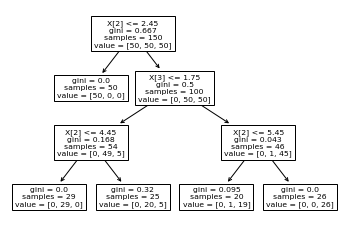

In [12]:
datasetIris = datasets.load_iris()
classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                         max_depth = 20,
                                         min_samples_leaf = 20,
                                         splitter = 'best')
tree.plot_tree(classifier.fit(datasetIris.data, datasetIris.target), max_depth=5)
display('Holdout', decision_tree_results_df[(decision_tree_results_df['dataset']=='iris') & (decision_tree_results_df['split']=='holdout')])
display('K-Fold', decision_tree_results_df[(decision_tree_results_df['dataset']=='iris') & (decision_tree_results_df['split']=='k-fold')])

### Handwritten Numbers
As for the digits dataset, the results show high similarity to the Iris dataset.

As expected, results are somewhat lower in terms of accuracy, precision and recall due to the added complexity caused by the higher number of dimensions/criteria.

The results indicate that the decision tree performs best, if a maximum depth of 10 is defined. Any deeper tree seems to be resulting in an overfitted solution.
Additionally, increased values for `min_samples_leaf` do also seem to counteract this issue. Since `max_depth` strongly interacts with the amount to which `min_samples_leaf` is relevant, this was also expected.

Again, consistency of results across all parameters as measured by the deviation of the k-fold results was sufficient.

'Holdout'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
48,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.673401,0.717454,0.677103,0.00299215,0
50,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.6633,0.746121,0.663671,0.00797844,0
52,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.643098,0.637573,0.641345,0.00199509,0.000994444
54,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.658249,0.720075,0.657125,0.00700927,0.000997066
56,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.644781,0.641595,0.644134,0.00299454,0
58,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.604377,0.594411,0.602063,0.00698042,0
60,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",holdout,0.553872,0.457052,0.551979,0.00199509,0.00099802
62,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",holdout,0.56229,0.416149,0.560637,0.00498343,0
64,digits,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",holdout,0.821549,0.827151,0.822762,0.00398922,0.000996828
66,digits,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",holdout,0.833333,0.84214,0.836688,0.0119731,0


'K-Fold'

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
49,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.682799442896936 std: 0.0225789955736832,m: 0.717660567564935 std: 0.026132446284686445,m: 0.6822451106568753 std: 0.022306835943359964,total: 0.019972562789916992 values: [0.0039928...,total: 0.00798487663269043 values: [0.00199485...
51,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.6521990095945527 std: 0.029293764851288196,m: 0.7298174310895975 std: 0.01717008365700091,m: 0.6520541549953315 std: 0.028721061472361847,total: 0.05086183547973633 values: [0.00997353...,total: 0.007980585098266602 values: [0.0019955...
53,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.6750278551532034 std: 0.040755563742608684,m: 0.6950497115958991 std: 0.061857032803490745,m: 0.674860019683549 std: 0.04133979548873456,total: 0.018950223922729492 values: [0.0029909...,total: 0.009939908981323242 values: [0.0019919...
55,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.642189724543485 std: 0.026859596447899876,m: 0.703735266738326 std: 0.01501969790860612,m: 0.6420215509627274 std: 0.026807715646732715,total: 0.04686760902404785 values: [0.00897169...,total: 0.008948087692260742 values: [0.0019950...
57,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.6138037759207675 std: 0.03143654702842772,m: 0.5967887573005678 std: 0.06100467422974398,m: 0.6139059227294522 std: 0.030674770972497722,total: 0.018919944763183594 values: [0.0039560...,total: 0.008007049560546875 values: [0.0010280...
59,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.6087991333952336 std: 0.02155766250476341,m: 0.5973590162149752 std: 0.009284347689610771,m: 0.6088272137683901 std: 0.021919764624072094,total: 0.04587531089782715 values: [0.00897598...,total: 0.007979393005371094 values: [0.0019946...
61,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",k-fold,m: 0.5893438563912101 std: 0.03173362414087538,m: 0.579646675872107 std: 0.05968815181600509,m: 0.5890082519494284 std: 0.03240890002469844,total: 0.015943288803100586 values: [0.0029907...,total: 0.007976055145263672 values: [0.0009949...
63,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 100\n, Split...",k-fold,m: 0.5748529866914268 std: 0.019348148703598324,m: 0.5292529056471827 std: 0.028829445795346305,m: 0.5747628637040401 std: 0.020718690800290554,total: 0.03793072700500488 values: [0.00797582...,total: 0.009973764419555664 values: [0.0019960...
65,digits,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",k-fold,m: 0.8492169606932837 std: 0.024701250873822116,m: 0.8535964619626707 std: 0.024247845316340284,m: 0.848803896333308 std: 0.024983989383474584,total: 0.02992558479309082 values: [0.00598907...,total: 0.00797128677368164 values: [0.00099516...
67,digits,Decision Tree Classifier,"max Depth: 10\n, min Samples/Leaf: 2\n, Splitt...",k-fold,m: 0.8497415660786135 std: 0.016289255420700997,m: 0.8559045305923447 std: 0.016949978229067093,m: 0.8496446109975521 std: 0.016132101050840803,total: 0.07882189750671387 values: [0.0159533 ...,total: 0.00894618034362793 values: [0.00199842...


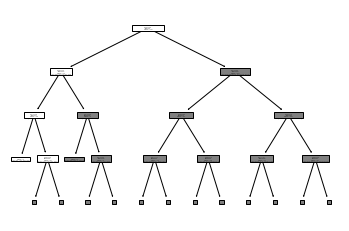

In [13]:
datasetDigits = datasets.load_digits()
classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                         max_depth = 20,
                                         min_samples_leaf = 20,
                                         splitter = 'best')
tree.plot_tree(classifier.fit(datasetDigits.data, datasetDigits.target),max_depth=3)

display('Holdout', decision_tree_results_df[(decision_tree_results_df['dataset']=='digits') & (decision_tree_results_df['split']=='holdout')])
display('K-Fold', decision_tree_results_df[(decision_tree_results_df['dataset']=='digits') & (decision_tree_results_df['split']=='k-fold')])

# Overall Results
## Approach Specific Findings
Findings specific to the separate approaches and their potential interactions with the dataset they were applied on, were already discussed in the previous sections.

The following will hence only focus on a comparison of the approaches.

In [14]:
overall_results = knn_results + bayes_results + perceptron_results + decision_tree_results
overall_results_df = pd.DataFrame(overall_results)

## Iris Dataset
### Holdout

In [15]:
display(overall_results_df[
            (overall_results_df['dataset']=='iris') &
            (overall_results_df['split']=='holdout')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,kNN,n=5,holdout,0.96,0.958333,0.968254,0.000997305,0.00199413
2,iris,kNN,n=10,holdout,0.92,0.925926,0.936508,0,0.00199461
4,iris,kNN,n=20,holdout,0.88,0.9,0.904762,0.000997782,0.000996828
12,iris,bayes,none,holdout,0.9,0.90305,0.912698,0.00099802,0
16,iris,perceptron,none,holdout,0.34,0.432624,0.4,0.00299144,0
20,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.88,0.890278,0.865079,0,0
22,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.9,0.90305,0.912698,0.000997543,0
24,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.48,0.45,0.555556,0,0
26,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.9,0.90305,0.912698,0,0
28,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.28,0.0933333,0.333333,0.00099802,0


### K Fold

In [16]:
display(overall_results_df[
            (overall_results_df['dataset']=='iris') &
            (overall_results_df['split']=='k-fold')])


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,kNN,n=5,k-fold,m: 0.96 std: 0.038873012632301994,m: 0.9610774410774411 std: 0.03826764858710283,m: 0.96 std: 0.03887301263230201,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.012964487075805664 values: [0.0039892...
3,iris,kNN,n=10,k-fold,m: 0.9733333333333334 std: 0.05333333333333332,m: 0.975 std: 0.049999999999999996,m: 0.9733333333333334 std: 0.053333333333333365,total: 0.000997304916381836 values: [0.0009973...,total: 0.011967658996582031 values: [0.0019938...
5,iris,kNN,n=20,k-fold,m: 0.9466666666666667 std: 0.04521553322083511,m: 0.9517676767676768 std: 0.042228383872089235,m: 0.9466666666666667 std: 0.04521553322083516,total: 0.002991914749145508 values: [0. ...,total: 0.011002540588378906 values: [0.0019946...
13,iris,bayes,none,k-fold,m: 0.9533333333333334 std: 0.03399346342395189,m: 0.9550168350168351 std: 0.03375719358407477,m: 0.9533333333333334 std: 0.0339934634239519,total: 0.0029921531677246094 values: [0. ...,total: 0.006980180740356445 values: [0.0019941...
17,iris,perceptron,none,k-fold,m: 0.74 std: 0.10413666234542207,m: 0.6742889463477699 std: 0.19998100699035673,m: 0.74 std: 0.10413666234542203,total: 0.009029150009155273 values: [0.0020175...,total: 0.005954265594482422 values: [0.0010025...
21,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.8800000000000001 std: 0.05416025603090639,m: 0.9151709401709403 std: 0.02856862378351845,m: 0.8799999999999999 std: 0.05416025603090637,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.004987239837646484 values: [0.0009968...
23,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.004986286163330078 values: [0.0009975...,total: 0.004987001419067383 values: [0.0009975...
25,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.5599999999999999 std: 0.024944382578492935,m: 0.47716293368467283 std: 0.004696804926703416,m: 0.5599999999999999 std: 0.024944382578492935,total: 0.003989696502685547 values: [0. ...,total: 0.004985809326171875 values: [0.0009973...
27,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.9266666666666667 std: 0.04422166387140532,m: 0.9332491582491583 std: 0.04255264892173636,m: 0.9266666666666665 std: 0.044221663871405345,total: 0.0 values: [0. 0. 0. 0. 0.],total: 0.006012678146362305 values: [0.0019941...
29,iris,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.003996610641479492 values: [0.0009989...,total: 0.005975484848022461 values: [0.0009946...


### Effectiveness
Despite the heterogenous approaches used, acccuracy, precision and recall were good across most approaches with the notable exception of the Perceptron.

The results also showed specific strengths and weaknesses of the approaches used when applied to this specific dataset: While the decision tree was well applicable for the low dimensionality of the problem, the perceptron showed some issues in dealing with the data set.

However, with the high accuracy, precision and recall accross the methods applied, the data set may be prone to ceiling effects when it comes to measuring effectiveness for these categorization tasks.

### Efficiency
In the datasets used as well as in the approaches applied, the training and testing time measured were low to non-measurable.

Benchmarking with these limited differences across approaches would be too prone to additional confounding variables such as running background tasks and other effects not associated with the machine learning tasks.

Generally speaking, all approaches used seem to be widely applicable for similar problems without having to think about specific computational requirements.

## Handwritten Numbers Dataset
### Holdout

In [17]:
display(overall_results_df[
            (overall_results_df['dataset']=='digits') &
            (overall_results_df['split']=='holdout')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
6,digits,kNN,n=5,holdout,0.983165,0.983364,0.983174,0.0169556,0.0917222
8,digits,kNN,n=10,holdout,0.976431,0.976702,0.976281,0.0159883,0.0927207
10,digits,kNN,n=20,holdout,0.961279,0.962286,0.961089,0.0159895,0.0967364
14,digits,bayes,none,holdout,0.833333,0.850641,0.833908,0.00199485,0.00199413
18,digits,perceptron,none,holdout,0.939394,0.94141,0.93962,0.024905,0
68,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.673401,0.717454,0.677103,0.00299215,0
70,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",holdout,0.6633,0.746121,0.663671,0.00797844,0
72,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.643098,0.637573,0.641345,0.00199509,0.000994444
74,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",holdout,0.658249,0.720075,0.657125,0.00700927,0.000997066
76,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",holdout,0.644781,0.641595,0.644134,0.00299454,0


### K Fold

In [18]:
display(overall_results_df[
            (overall_results_df['dataset']=='digits') &
            (overall_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
7,digits,kNN,n=5,k-fold,m: 0.9883163107397092 std: 0.005388572629804117,m: 0.9887866449971712 std: 0.005222598238459717,m: 0.9882804905746081 std: 0.0053145264097686756,total: 0.10274100303649902 values: [0.0249238 ...,total: 0.3141286373138428 values: [0.06482625 ...
9,digits,kNN,n=10,k-fold,m: 0.9805277004023523 std: 0.007241231361602902,m: 0.9816830468409415 std: 0.00662931853158472,m: 0.9804048249930603 std: 0.00715395193374626,total: 0.09673857688903809 values: [0.01994586...,total: 0.3151588439941406 values: [0.06283236 ...
11,digits,kNN,n=20,k-fold,m: 0.9705060352831941 std: 0.006724967766856801,m: 0.9717214434156635 std: 0.006292571449491544,m: 0.9702434451257981 std: 0.00681107277803136,total: 0.0977318286895752 values: [0.02094245 ...,total: 0.32610177993774414 values: [0.06682587...
15,digits,bayes,none,k-fold,m: 0.8324945837202105 std: 0.009286635323422067,m: 0.8598088622118409 std: 0.015147678383072103,m: 0.8325454614278144 std: 0.009764788694682724,total: 0.011956453323364258 values: [0.0019946...,total: 0.012965202331542969 values: [0.0029916...
19,digits,perceptron,none,k-fold,m: 0.9410229031259671 std: 0.015849668296257387,m: 0.9472330796425998 std: 0.01371753706347739,m: 0.9410189264895147 std: 0.015777826142176866,total: 0.13765859603881836 values: [0.02895617...,total: 0.007979154586791992 values: [0.0019922...
69,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.682799442896936 std: 0.0225789955736832,m: 0.717660567564935 std: 0.026132446284686445,m: 0.6822451106568753 std: 0.022306835943359964,total: 0.019972562789916992 values: [0.0039928...,total: 0.00798487663269043 values: [0.00199485...
71,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 2\n, Splitti...",k-fold,m: 0.6521990095945527 std: 0.029293764851288196,m: 0.7298174310895975 std: 0.01717008365700091,m: 0.6520541549953315 std: 0.028721061472361847,total: 0.05086183547973633 values: [0.00997353...,total: 0.007980585098266602 values: [0.0019955...
73,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.6750278551532034 std: 0.040755563742608684,m: 0.6950497115958991 std: 0.061857032803490745,m: 0.674860019683549 std: 0.04133979548873456,total: 0.018950223922729492 values: [0.0029909...,total: 0.009939908981323242 values: [0.0019919...
75,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 20\n, Splitt...",k-fold,m: 0.642189724543485 std: 0.026859596447899876,m: 0.703735266738326 std: 0.01501969790860612,m: 0.6420215509627274 std: 0.026807715646732715,total: 0.04686760902404785 values: [0.00897169...,total: 0.008948087692260742 values: [0.0019950...
77,digits,Decision Tree Classifier,"max Depth: 5\n, min Samples/Leaf: 50\n, Splitt...",k-fold,m: 0.6138037759207675 std: 0.03143654702842772,m: 0.5967887573005678 std: 0.06100467422974398,m: 0.6139059227294522 std: 0.030674770972497722,total: 0.018919944763183594 values: [0.0039560...,total: 0.008007049560546875 values: [0.0010280...


### Effectiveness
Again, accuracy, precision and recall were good across all approaches. In this specific case, also the perceptron yielded notable better results.

Most notably were the more nuanced results of the decision tree. As noted above, this is related to the higher complexity/dimensionality of a image recognition tasks, even with the low resolution of the digits dataset.

Surprisingly for the author, the results were still adequate for this task despite the fact, that the issue of potential overfitting became apparent very fast, when increasing the maximum depth or the minimum number of values per Leaf/Node.

Again, the still limited complexity of the data set may be prone to ceiling effects for measuring effectiveness of the approaches for image recognition tasks.

### Efficiency
Similar to the Iris dataset the training and testing times measured were low to non-measurable.

Benchmarking with these limited differences across approaches would be too prone to additional confounding variables such as running background tasks and other effects not associated with the machine learning tasks.
Larger and more complex datasets would yield more meaningful results in terms of efficiency.